# Image Blending

int64
int64


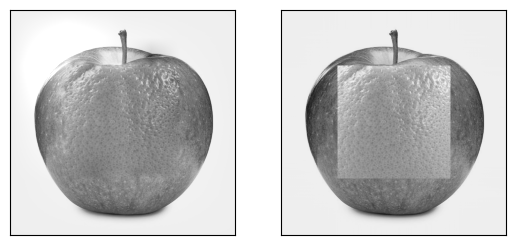

int64
int64


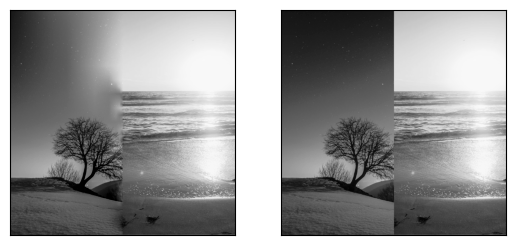

In [75]:
from scipy.signal import convolve2d
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt


def show_image(images):
    if len(images) == 1:
        plt.imshow(255-images[0],cmap='Grays',vmin=0,vmax=255)
    else:
        f,axis = plt.subplots(nrows=1,ncols=len(images))
        for i in range(len(images)):
            axis[i].imshow(255-images[i],cmap='Grays',vmin=0,vmax=255)
            axis[i].axes.get_xaxis().set_visible(False)
            axis[i].axes.get_yaxis().set_visible(False)
    plt.show()

def load_image_to_grays(path : str):
    image = np.asarray(Image.open(path))
    return np.round(0.299*image[:, :, 0]+0.587 * image[:, :, 1]+0.114*image[:, :,  2]).astype(np.uint8)

def get_gausse_pyramid(image):
    size = image.shape[0]
    levels_count = int(np.log2(size))
    levels = []
    levels.append(image)
    for i in range(1,levels_count):
        levels.append(levels[-1][::2,::2])
    return levels

def crop_squre(image):
    size = np.min(image.shape)
    return image[:size,:size]

def fit_to_size(image,size):
    size_to_pad = (size - image.shape[0])
    t = np.abs(np.fft.ifft2(np.pad(np.fft.fftshift(np.fft.fft2(image)),(0,size_to_pad))))
    return ((t-np.min(t))/(np.max(t)-np.min(t))*255).astype('int')
def expand_image(image):
    N = image.shape[0]*2
    expaneded_image = np.zeros((N,N))
    expaneded_image[::2,::2] = image
    expaneded_image[:,:] = convolve2d(expaneded_image,np.array([[1/2,1,1/2]]),mode='same')
    expaneded_image[:,:] = convolve2d(expaneded_image,np.array([[1/2],[1],[1/2]]),mode='same')
    return expaneded_image

def get_laplace_pyramid(image):
    pyramid = []
    for i in range(1,len(image)):
        pyramid.append(image[i-1]-expand_image(image[i]))
    return pyramid

def merge_images(image1,image2,mask):
    if mask.shape[0] != image1.shape[0] or mask.shape[0] != image2.shape[0] or mask.shape[1] != image1.shape[1] or mask.shape[1] != image2.shape[1]:
        raise Exception(f'images and mask have to be in the same size\n Got {image1.shape} {image2.shape} {mask.shape}')
    return image1*mask+(1-mask)*image2 

def blend(image1,image2,mask):
    mask_gause = get_gausse_pyramid(mask)
    gause1 = get_gausse_pyramid(image1)
    laplace1 = get_laplace_pyramid(gause1)
    gause2 = get_gausse_pyramid(image2)
    laplace2 = get_laplace_pyramid(gause2)
    blend_laplace = []
    size = min(len(laplace2),len(laplace1))
    base = merge_images(gause1[-1],gause2[-1],mask_gause[-1])
    print(base.dtype)
    print(mask.dtype)
    for i in range(-1,-size-1,-1):
        base = expand_image(base) + merge_images(laplace1[i],laplace2[i],mask_gause[i-1])
    return base

N = 2**10
image1 = load_image_to_grays("./apple.jpeg")
image2 = load_image_to_grays("./orange.jpeg")
image1 = fit_to_size(image1,N)
image2 = fit_to_size(image2,N)
N = image1.shape[0]
mask = np.zeros((N,N),'int')
mask[N//4:-N//4,N//4:-N//4] = 1
mask = 1- mask

show_image([blend(image1,image2,mask),merge_images(image1,image2,mask)])

N = 2**11
image1 = crop_squre(load_image_to_grays("./image1.jpg"))
image2 = crop_squre(load_image_to_grays("./image2.jpeg"))
image1 = fit_to_size(image1,N)
image2 = fit_to_size(image2,N)
N = image1.shape[0]
mask = np.zeros((N,N))
mask[:,N//2:] = 1
mask = 1- mask

show_image([blend(image1,image2,mask),merge_images(image1,image2,mask)])

(array([0, 1], dtype=uint8), array([137560, 672440]))


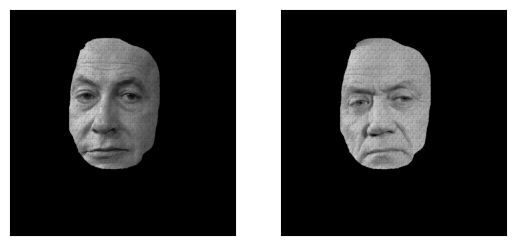

float64
float64
float64
float64


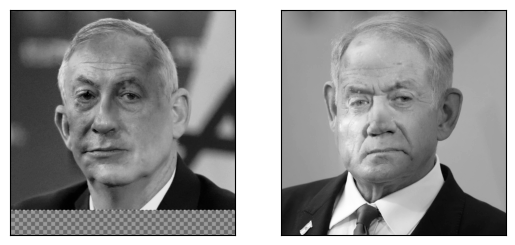

In [76]:
N = 2**10
image1 = crop_squre(load_image_to_grays("./BIBI.png"))
image2 = crop_squre(load_image_to_grays("./GANZ.png"))
mask = crop_squre(load_image_to_grays("./BIBIGANZMASK.png"))
image1 = fit_to_size(image1,N)
image2 = fit_to_size(image2,N)
mask[np.where(mask == 0)],mask[np.where(mask > 0)]=0,1
print(np.unique(mask,return_counts=True))
mask = 1-np.round(fit_to_size(mask,N)/255)
show_image([image1*mask,image2*mask])

show_image([blend(image1,image2,mask),blend(image1,image2,1-mask)])

float64
float64


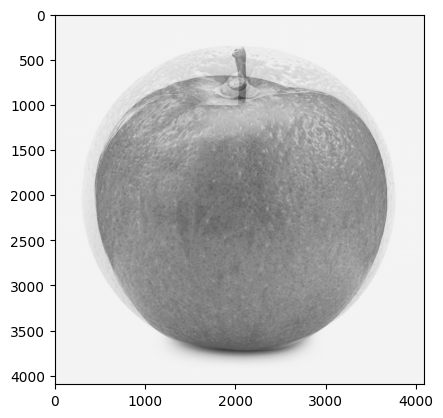

[[  0.     0.     0.   ...   0.     0.   122.5 ]
 [  0.     0.     0.   ...   0.     0.   122.5 ]
 [  0.     0.     0.   ...   0.     0.   122.5 ]
 ...
 [  0.     0.     0.   ...   0.     0.   122.5 ]
 [  0.     0.     0.   ...   0.     0.   122.5 ]
 [122.5  122.5  122.5  ... 122.5  122.5  183.75]]


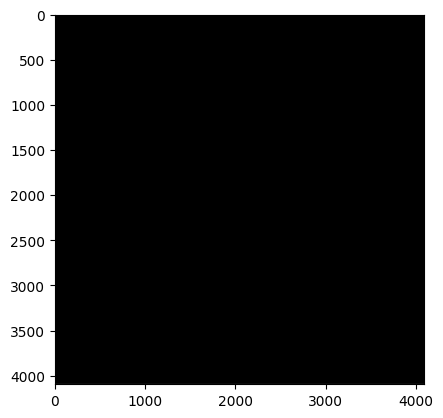

In [85]:
def hybrid(image1,image2):
    gause1 = get_gausse_pyramid(image1)
    laplace1 = get_laplace_pyramid(gause1)
    gause2 = get_gausse_pyramid(image2)
    laplace2 = get_laplace_pyramid(gause2)
    size = min(len(laplace2),len(laplace1))
    base = gause1[-1]
    for i in range(-1,(-size-1),-1):
        base = expand_image(base) + laplace1[i] if i%2==0 else laplace2[i]
    return base

N = 2**12
image1 = load_image_to_grays("./apple.jpeg")
image2 = load_image_to_grays("./orange.jpeg")
image1 = fit_to_size(image1,N)
image2 = fit_to_size(image2,N)
N = image1.shape[0]
mask = np.zeros((N,N))
mask[:,:] = 0.5

show_image([blend(image1,image2,mask)])
print(hybrid(image1,image2))
show_image([hybrid(image1,image2)])
